# Project of GDP prediction
**Predict GDP without directly using the previous GDP as a predictor(We do not tell the algorithem to predict GDP to avoid "cheating").**

# Brief description
This project is structured into five distinct phases:
1.	Gathering and normalizing data:
Data will be downloaded from official websites such as FED databases. Following collection, continuous data will undergo normalization processes using Sklearn's MinMaxScaler or StandardScaler to adjust the data into a suitable format for analysis. This approach can also improve the stability and performance of the models. In parallel, categorical data will be transformed into numerical formats using Sklearn's OneHotEncoder, which is essential for the following machine learning processes.
2.	Data preprocessing:
Once the data is ready, it's divided into three distinct sets: training, validation, and test sets, with proportions of 70%, 15%, and 15%, respectively. This division is prepared for the following hyperparameter tuning and model selection. 
3.	Model training and hyperparameter tuning:
Different types of models will be trained only using training set in this stage before making a final decision. Models will include traditional machine learning models such as Ridge Regression, Lasso Regression, XGBoost, Random Forest, SVM, as well as some more sophisticated deep learning model such as 1D convolution neural network, which is generally considered suitable for analyzing sequential data. The models will be tuned, with hyperparameters adjusted to optimize performance, as measured by the Mean Square Error (MSE) on the validation set. Each predicting variable, as well as the GDP growth, will have its own set of models.
4.	Model testing and model choosing:
This stage applies the previously separated test set to evaluate the performance of each model, specifically looking at their MSE scores. The model that exhibits the lowest MSE for predicting each variable is selected as the final model for that specific variable. 
5.	Prediction:
Suppose we are at time t, and we have gathered all the data we need at time t. We predict the t+1 value of variables except GDP growth using all the data at time t through the trained models. Those t+1 variables will be used to predict the t+1 GDP growth. Using the same method, we predict the GDP growth at time t+2, t+3, t+4 and t+5.


# Data Preprocessing

**split data to train, val, test folders**

In [1]:
import pandas as pd
import numpy as np

In [2]:
main_form = pd.read_csv("d:\econ1500\data\Main_form.csv")
# main_form.set_index('DATE', drop=False, inplace=True)
main_form = main_form.drop(['Year', 'DATE'], axis=1)

main_form_target = {}
main_form_features = {}
x_train = {}
x_val = {}
x_test = {}
y_train = {}
y_val = {}
y_test = {}

for i in main_form.columns:
    main_form_target[i] = main_form[[i]].shift(-1)
    main_form_features[i] = main_form
    # main_form_features[i] = main_form.drop([i], axis= 1)

    #determine train, val, and test size
    train_size = 0.7
    val_size = 0.15
    test_size = 0.15

    train_end = int(len(main_form[i]) * train_size)
    val_end = int(len(main_form[i]) * (train_size + val_size))
    #split data
    x_train[i] = main_form_features[i][:train_end]
    x_val[i] = main_form_features[i][train_end:val_end]
    x_test[i] = main_form_features[i][val_end:-1]
    y_train[i] = main_form_target[i][:train_end]
    y_val[i] = main_form_target[i][train_end:val_end]
    y_test[i] = main_form_target[i][val_end:-1]



In [3]:
x_train['C']

,C,I,G,IM,EX,Temp,inflation,unemploy,LTGBY,pop_44,pop_64,top10
0,256.5,72.7,92.5,17.1,16.9,49.6,0.000000,4.7,2.75,47193.769,33506.057,36.70
1,260.7,74.7,94.1,17.4,18.1,49.6,0.499376,4.0,2.90,47193.769,33506.057,36.70
2,264.6,78.9,93.3,18.1,18.3,49.6,0.124224,4.3,2.88,47193.769,33506.057,36.70
3,266.2,78.3,94.8,18.9,19.4,51.5,-0.248139,4.0,2.90,47378.935,34057.117,35.74
4,268.8,77.0,98.2,19.0,20.9,51.5,0.870647,4.0,3.18,47378.935,34057.117,35.74
...,...,...,...,...,...,...,...,...,...,...,...,...
187,7217.7,1912.7,2040.0,1356.0,969.2,52.0,0.357277,5.7,5.04,83990.295,66695.526,41.49
188,7308.0,1933.3,2074.5,1432.4,1004.2,52.0,1.086753,5.9,5.21,83990.295,66695.526,41.49
189,7397.1,1933.2,2101.3,1463.1,1015.6,52.0,0.426321,5.8,4.65,83990.295,66695.526,41.49
190,7473.0,1942.5,2142.2,1499.3,1003.0,52.0,0.313769,5.7,3.94,83990.295,66695.526,41.49


In [4]:
y_train['C']

,C
0,260.7
1,264.6
2,266.2
3,268.8
4,272.1
...,...
187,7308.0
188,7397.1
189,7473.0
190,7567.2


# Check and handel missing values

**Check missing value in all train tables**

In [5]:
for i in main_form.columns:
    print('check training table', i, 'column for missing data')
    # print('data dimensions of train set:',x_train[i].shape)
    perc_missing_per_ftr = x_train[i].isnull().sum(axis=0)/x_train[i].shape[0]
    print(perc_missing_per_ftr)
    if sum(perc_missing_per_ftr) > 0:
        print('fraction of missing values in features:')
        print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
    else:
        print('No missing data in all features')
    if sum(x_train[i].isnull().sum(axis=1)!=0)/x_train[i].shape[0]>0:
        frac_missing = sum(x_train[i].isnull().sum(axis=1)!=0)/x_train[i].shape[0]
        print('fraction of points with missing values:',frac_missing)
    else:
        print('No missing data in this tabel')
    print()

check training table C column for missing data
C            0.0
I            0.0
G            0.0
IM           0.0
EX           0.0
Temp         0.0
inflation    0.0
unemploy     0.0
LTGBY        0.0
pop_44       0.0
pop_64       0.0
top10        0.0
dtype: float64
No missing data in all features
No missing data in this tabel

check training table I column for missing data
C            0.0
I            0.0
G            0.0
IM           0.0
EX           0.0
Temp         0.0
inflation    0.0
unemploy     0.0
LTGBY        0.0
pop_44       0.0
pop_64       0.0
top10        0.0
dtype: float64
No missing data in all features
No missing data in this tabel

check training table G column for missing data
C            0.0
I            0.0
G            0.0
IM           0.0
EX           0.0
Temp         0.0
inflation    0.0
unemploy     0.0
LTGBY        0.0
pop_44       0.0
pop_64       0.0
top10        0.0
dtype: float64
No missing data in all features
No missing data in this tabel

check trainin

*No missing data in all train tables detected*

**Check missing value in all val tables**

In [6]:
for i in main_form.columns:
    print('check val table', i, 'column for missing data')
    # print('data dimensions of train set:',x_train[i].shape)
    perc_missing_per_ftr = x_val[i].isnull().sum(axis=0)/x_val[i].shape[0]
    if sum(perc_missing_per_ftr) > 0:
        print('fraction of missing values in features:')
        print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
    else:
        print('No missing data in all features')
    if sum(x_val[i].isnull().sum(axis=1)!=0)/x_val[i].shape[0]>0:
        frac_missing = sum(x_val[i].isnull().sum(axis=1)!=0)/x_val[i].shape[0]
        print('fraction of points with missing values:',frac_missing)
    else:
        print('No missing data in this tabel')
    print()

check val table C column for missing data
No missing data in all features
No missing data in this tabel

check val table I column for missing data
No missing data in all features
No missing data in this tabel

check val table G column for missing data
No missing data in all features
No missing data in this tabel

check val table IM column for missing data
No missing data in all features
No missing data in this tabel

check val table EX column for missing data
No missing data in all features
No missing data in this tabel

check val table Temp column for missing data
No missing data in all features
No missing data in this tabel

check val table inflation column for missing data
No missing data in all features
No missing data in this tabel

check val table unemploy column for missing data
No missing data in all features
No missing data in this tabel

check val table LTGBY column for missing data
No missing data in all features
No missing data in this tabel

check val table pop_44 column f

*No missing data in all val table detected*

**Check missing value in all test tables**

In [7]:
for i in main_form.columns:
    print('check test table', i, 'column for missing data')
    # print('data dimensions of train set:',x_train[i].shape)
    perc_missing_per_ftr = x_test[i].isnull().sum(axis=0)/x_test[i].shape[0]
    if sum(perc_missing_per_ftr) > 0:
        print('fraction of missing values in features:')
        print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
    else:
        print('No missing data in all features')
    if sum(x_test[i].isnull().sum(axis=1)!=0)/x_test[i].shape[0]>0:
        frac_missing = sum(x_test[i].isnull().sum(axis=1)!=0)/x_test[i].shape[0]
        print('fraction of points with missing values:',frac_missing)
    else:
        print('No missing data in this tabel')
    print()

check test table C column for missing data
fraction of missing values in features:
top10    0.073171
dtype: float64
fraction of points with missing values: 0.07317073170731707

check test table I column for missing data
fraction of missing values in features:
top10    0.073171
dtype: float64
fraction of points with missing values: 0.07317073170731707

check test table G column for missing data
fraction of missing values in features:
top10    0.073171
dtype: float64
fraction of points with missing values: 0.07317073170731707

check test table IM column for missing data
fraction of missing values in features:
top10    0.073171
dtype: float64
fraction of points with missing values: 0.07317073170731707

check test table EX column for missing data
fraction of missing values in features:
top10    0.073171
dtype: float64
fraction of points with missing values: 0.07317073170731707

check test table Temp column for missing data
fraction of missing values in features:
top10    0.073171
dtype: fl

**mising value detected in test set, implement missing value with linear regression**

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

for i in main_form.columns:
    imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
    X_impute = imputer.fit_transform(x_test[i])
    y_impute = imputer.fit_transform(y_test[i])
    x_test[i] = pd.DataFrame(data=X_impute, columns = x_test[i].columns)
    y_test[i] = pd.DataFrame(data=y_impute, columns = y_test[i].columns)


# Column name discription
1. C        -   consumption (Billions of Dollars)
2. I        -   investment (Billions of Dollars)
3. G        -   government spending (Billions of Dollars)
4. IM       -   import ammount (Billions of Dollars)
5. EX       -   export ammount (Billions of Dollars)
6. unemploy -   unemployment rate (%)
7. LTGBY    -   Long Term Government Bond Yield(10 years) (%)
8. pop_44   -   population of age group 25-44 (thousand people)
9. pop_64   -   population of age group 45-64 (thousand people)
10. top10   -   top 10% pre-tax national income share (%)
11. temp    -   average tempreture (Fahrenheit)
12. inflation - inflation rate (%)

# Check some example tables here

In [9]:
x_train['C']

,C,I,G,IM,EX,Temp,inflation,unemploy,LTGBY,pop_44,pop_64,top10
0,256.5,72.7,92.5,17.1,16.9,49.6,0.000000,4.7,2.75,47193.769,33506.057,36.70
1,260.7,74.7,94.1,17.4,18.1,49.6,0.499376,4.0,2.90,47193.769,33506.057,36.70
2,264.6,78.9,93.3,18.1,18.3,49.6,0.124224,4.3,2.88,47193.769,33506.057,36.70
3,266.2,78.3,94.8,18.9,19.4,51.5,-0.248139,4.0,2.90,47378.935,34057.117,35.74
4,268.8,77.0,98.2,19.0,20.9,51.5,0.870647,4.0,3.18,47378.935,34057.117,35.74
...,...,...,...,...,...,...,...,...,...,...,...,...
187,7217.7,1912.7,2040.0,1356.0,969.2,52.0,0.357277,5.7,5.04,83990.295,66695.526,41.49
188,7308.0,1933.3,2074.5,1432.4,1004.2,52.0,1.086753,5.9,5.21,83990.295,66695.526,41.49
189,7397.1,1933.2,2101.3,1463.1,1015.6,52.0,0.426321,5.8,4.65,83990.295,66695.526,41.49
190,7473.0,1942.5,2142.2,1499.3,1003.0,52.0,0.313769,5.7,3.94,83990.295,66695.526,41.49


In [10]:
y_train['C']

,C
0,260.7
1,264.6
2,266.2
3,268.8
4,272.1
...,...
187,7308.0
188,7397.1
189,7473.0
190,7567.2


In [11]:
x_test['C']

,C,I,G,IM,EX,Temp,inflation,unemploy,LTGBY,pop_44,pop_64,top10
0,11408.4,2892.4,3135.2,2767.2,2285.1,53.3,0.377979,7.3,2.58,79303.672,83028.953,44.900000
1,11551.2,2934.3,3140.5,2783.3,2349.2,53.3,-0.279068,7.2,2.62,79303.672,83028.953,44.900000
2,11646.0,2922.8,3139.1,2853.7,2343.6,55.6,0.761223,6.6,2.86,79793.943,83315.025,45.580000
3,11810.5,3059.1,3154.4,2900.6,2395.2,55.6,1.180868,6.2,2.71,79793.943,83315.025,45.580000
4,11959.8,3142.0,3191.7,2888.5,2399.2,55.6,0.114676,6.2,2.54,79793.943,83315.025,45.580000
5,12081.6,3172.0,3189.3,2907.0,2376.2,55.6,-0.803352,5.7,2.30,79793.943,83315.025,45.580000
6,12119.8,3282.3,3187.9,2825.5,2299.0,56.3,-0.543199,5.7,1.88,80145.079,83759.351,45.500000
7,12264.1,3291.1,3234.1,2810.0,2300.4,56.3,1.205596,5.4,1.94,80145.079,83759.351,45.500000
8,12382.5,3303.7,3253.6,2798.8,2260.7,56.3,0.262677,5.2,2.32,80145.079,83759.351,45.500000
9,12423.4,3276.9,3258.1,2745.5,2222.3,56.3,-0.449844,5.0,2.07,80145.079,83759.351,45.500000


In [12]:
y_test['C']

,C
0,11551.2
1,11646.0
2,11810.5
3,11959.8
4,12081.6
5,12119.8
6,12264.1
7,12382.5
8,12423.4
9,12523.2


# Using standard scaler to standardize all the training data

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
X_train_prep = {}
X_val_prep = {}
X_test_prep = {}
for i in main_form.columns:

    std_ftrs = x_train[i].columns.tolist()
    preprocessor = ColumnTransformer(
        transformers = [('std', StandardScaler(), std_ftrs)])


    clf = Pipeline(steps = [('preprocessor', preprocessor)])

    X_train_prep[i] = clf.fit_transform(x_train[i])
    X_val_prep[i] = clf.transform(x_val[i])
    X_test_prep[i] = clf.transform(x_test[i])

# Calculate baseline MSE for each feature using the mean value of each feature

In [14]:
avg = {}
sum = {}
for i in main_form.columns:
    sum[i] = []
    avg[i] = np.nanmean(main_form[i].tolist())
    for row in range(main_form.shape[0]):
        temp = np.square(main_form[i][row] - avg[i])
        sum[i].append(temp)
    sum[i] = np.nanmean(sum[i])
print(sum)

{'C': 25468962.522232592, 'I': 1710774.581276562, 'G': 1753235.0764289584, 'IM': 1367852.3225261488, 'EX': 814705.2001420165, 'Temp': 3.1430976528925623, 'inflation': 0.6451650707048842, 'unemploy': 2.9163324297520665, 'LTGBY': 8.438160177190083, 'pop_44': 240264482.2452566, 'pop_64': 312997802.9456197, 'top10': 19.029600065358586}


In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
MSE_score = pd.DataFrame.from_dict(sum, orient='index', columns = ['Baseline'])
MSE_score

,Baseline
C,25468962.522
I,1710774.581
G,1753235.076
IM,1367852.323
EX,814705.200
Temp,3.143
inflation,0.645
unemploy,2.916
LTGBY,8.438
pop_44,240264482.245


# Ridge Model
**Hyper-parameter to be tuned: alpha value**

In [16]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
param_grid = {'regressor__alpha': alpha_values}

train_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))
val_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))

test_rmse_scores_ridge = {}
final_models_ridge = {}
for i in main_form.columns:
    models = []
    base_rmse_test_ridge = []
    base_rmse_val_ridge = []
    val_rmse_scores_ridge = []

    print('---------------------------------------')
    print('Ridge model to predict', i)
    for p, params in enumerate(ParameterGrid(param_grid)):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            
            model = Ridge(alpha=params['regressor__alpha'], solver = 'saga' ,random_state=42, max_iter=10000)
            
            model.fit(X_train_prep[i],y_train[i]) 
            models.append(model) 
            
            y_train_pred = model.predict(X_train_prep[i])
            train_rmse_score_ridge[p] = mean_squared_error(y_train[i], y_train_pred)
            y_val_pred = model.predict(X_val_prep[i])
            val_rmse_score_ridge[p] = mean_squared_error(y_val[i], y_val_pred)
            print('   ', train_rmse_score_ridge[p],val_rmse_score_ridge[p])
    

   
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_rmse_score_ridge)])
    print('corresponding validation score:',np.min(val_rmse_score_ridge))
 

    
    final_models_ridge[i] = (models[np.argmin(val_rmse_score_ridge)])
    
    y_test_pred = final_models_ridge[i].predict(X_test_prep[i])
        
    test_rmse_scores_ridge[i] = mean_squared_error(y_test[i], y_test_pred)
    print('test score:',test_rmse_scores_ridge[i])
    

---------------------------------------
Ridge model to predict C
    {'regressor__alpha': 0.0001}
    253.3821101966481 35629.50452278694
    {'regressor__alpha': 0.001}
    256.6953591836064 37669.727697640104
    {'regressor__alpha': 0.01}
    289.96468909365683 56843.53392071852
    {'regressor__alpha': 0.1}
    557.8185809382312 154082.11537962788
    {'regressor__alpha': 1}
    1581.1861569106125 123957.34740190106
    {'regressor__alpha': 10}
    5027.372645026687 44994.590462005464
    {'regressor__alpha': 100}
    30558.27435266641 404297.7769866126
    {'regressor__alpha': 150}
    53222.672391383116 749425.9435081384
    {'regressor__alpha': 200}
    81060.44992771605 1153564.5873739722
    {'regressor__alpha': 250}
    113197.85105992835 1602632.7140495395
    {'regressor__alpha': 300}
    148865.10572059636 2086522.8299288852
    {'regressor__alpha': 350}
    187398.03852130007 2597345.8242911133
    {'regressor__alpha': 400}
    228229.26719914973 3128737.5855750684
    {'

**Store the MSE results in the table**

In [17]:
MSE_ridge = pd.DataFrame.from_dict(test_rmse_scores_ridge, orient='index', columns=['Ridge'])
MSE_score = MSE_score.join(MSE_ridge)
MSE_score


,Baseline,Ridge
C,25468962.522,107222.855
I,1710774.581,130226.925
G,1753235.076,15126.933
IM,1367852.323,24251.675
EX,814705.200,41006.310
Temp,3.143,0.710
inflation,0.645,0.619
unemploy,2.916,3.504
LTGBY,8.438,0.430
pop_44,240264482.245,9602727.134


**Store the best tuned hyper-parameter into the model**

In [18]:
final_models_ridge

{'C': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'I': Ridge(alpha=0.1, max_iter=10000, random_state=42, solver='saga'),
 'G': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'IM': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'EX': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'Temp': Ridge(alpha=1, max_iter=10000, random_state=42, solver='saga'),
 'inflation': Ridge(alpha=700, max_iter=10000, random_state=42, solver='saga'),
 'unemploy': Ridge(alpha=10, max_iter=10000, random_state=42, solver='saga'),
 'LTGBY': Ridge(alpha=10, max_iter=10000, random_state=42, solver='saga'),
 'pop_44': Ridge(alpha=0.001, max_iter=10000, random_state=42, solver='saga'),
 'pop_64': Ridge(alpha=0.0001, max_iter=10000, random_state=42, solver='saga'),
 'top10': Ridge(alpha=0.1, max_iter=10000, random_state=42, solver='saga')}

# Lasso Model
**Hyper-parameter to be tuned: alpha values**

In [19]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
param_grid = {'regressor__alpha': alpha_values}

train_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))
val_rmse_score_ridge = np.zeros(len(ParameterGrid(param_grid)))

param_grid = {'regressor__alpha': alpha_values}
test_rmse_scores_lasso = {}
final_models_lasso = {}
for i in main_form.columns:
    models = []
    base_rmse_test_lasso = []
    base_rmse_val_lasso = []
    val_rmse_scores_lasso = []

    print('---------------------------------------')
    print('Lasso model to predict', i)
    for p, params in enumerate(ParameterGrid(param_grid)):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
            
        model = Lasso(alpha=params['regressor__alpha'], selection = 'random' ,random_state=42, max_iter=100000)
            
        model.fit(X_train_prep[i],y_train[i]) 
        models.append(model) 
            
        y_train_pred = model.predict(X_train_prep[i])
        train_rmse_score_ridge[p] = mean_squared_error(y_train[i], y_train_pred)
        y_val_pred = model.predict(X_val_prep[i])
        val_rmse_score_ridge[p] = mean_squared_error(y_val[i], y_val_pred)
            
        print('   ', train_rmse_score_ridge[p],val_rmse_score_ridge[p])
        

    final_models_lasso[i] = (models[np.argmin(val_rmse_score_ridge)])
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_rmse_score_ridge)])
    print('corresponding validation score:',np.min(val_rmse_score_ridge))
 

    
    
    
    y_test_pred = final_models_lasso[i].predict(X_test_prep[i])
        
    test_rmse_scores_lasso[i] = mean_squared_error(y_test[i], y_test_pred)
    print('test score:',test_rmse_scores_lasso[i])
    

---------------------------------------
Lasso model to predict C
    {'regressor__alpha': 0.0001}
    853.34297735706 346191.2299167934
    {'regressor__alpha': 0.001}
    853.4281828065004 346077.82428146515
    {'regressor__alpha': 0.01}
    854.2906576075287 344944.54222145706
    {'regressor__alpha': 0.1}
    899.098404809496 347491.28376544587
    {'regressor__alpha': 1}
    653.9695269286975 190425.94499301285
    {'regressor__alpha': 10}
    508.33882560499455 56107.4824811509
    {'regressor__alpha': 100}
    10427.489113251755 53173.632805180576
    {'regressor__alpha': 150}
    23201.108340206923 135429.3594352224
    {'regressor__alpha': 200}
    40703.991870823105 340313.4384981366
    {'regressor__alpha': 250}
    63553.043544394975 626020.2845492733
    {'regressor__alpha': 300}
    90315.64575255314 846497.725739255
    {'regressor__alpha': 350}
    123910.28705875936 1267757.7773981132
    {'regressor__alpha': 400}
    160313.54026482787 1709593.9173548499
    {'regress

**Store the MSE results into the table**

In [20]:
lasso_regre = pd.DataFrame.from_dict(test_rmse_scores_lasso, orient = 'index', columns=['Lasso'])
MSE_score = MSE_score.join(lasso_regre)
MSE_score

,Baseline,Ridge,Lasso
C,25468962.522,107222.855,443346.958
I,1710774.581,130226.925,31549.265
G,1753235.076,15126.933,1517.875
IM,1367852.323,24251.675,22799.717
EX,814705.200,41006.310,18553.339
Temp,3.143,0.710,0.836
inflation,0.645,0.619,0.732
unemploy,2.916,3.504,3.704
LTGBY,8.438,0.430,0.187
pop_44,240264482.245,9602727.134,868074.629


**Store the best tuned hyper-parameter into the model**

In [21]:
final_models_lasso

{'C': Lasso(alpha=100, max_iter=100000, random_state=42, selection='random'),
 'I': Lasso(alpha=1, max_iter=100000, random_state=42, selection='random'),
 'G': Lasso(alpha=1, max_iter=100000, random_state=42, selection='random'),
 'IM': Lasso(alpha=0.01, max_iter=100000, random_state=42, selection='random'),
 'EX': Lasso(alpha=1, max_iter=100000, random_state=42, selection='random'),
 'Temp': Lasso(alpha=0.1, max_iter=100000, random_state=42, selection='random'),
 'inflation': Lasso(alpha=1, max_iter=100000, random_state=42, selection='random'),
 'unemploy': Lasso(alpha=0.01, max_iter=100000, random_state=42, selection='random'),
 'LTGBY': Lasso(alpha=0.01, max_iter=100000, random_state=42, selection='random'),
 'pop_44': Lasso(alpha=300, max_iter=100000, random_state=42, selection='random'),
 'pop_64': Lasso(alpha=100, max_iter=100000, random_state=42, selection='random'),
 'top10': Lasso(alpha=0.1, max_iter=100000, random_state=42, selection='random')}

# XGBoost Model
**Hyper-parameter to be tuned: learning rate, max_depth, n_estimators**

In [22]:
#XGBoost
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import warnings


warnings.filterwarnings('ignore', message='`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.', category=UserWarning)


param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1 , 2, 3, 4, 5],
    "missing": [np.nan], 
    'n_estimators': [25, 50, 100, 200], 
    'min_child_weight': [0.5, 1, 1.5, 2]
    
}


test_rmse_scores_xgb = {}
best_models_xgb = {}
for i in main_form.columns:
    print('---------------------------------------')
    print('XGBoost model to predict', i)

    model = XGBRegressor(eval_metric="rmse")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
    grid_search.fit(X_train_prep[i], y_train[i])

    
    best_model = grid_search.best_estimator_
    best_models_xgb[i] = best_model

   
    y_train_pred = best_model.predict(X_train_prep[i])
    y_val_pred = best_model.predict(X_val_prep[i])
    y_test_pred = best_model.predict(X_test_prep[i])
    
    train_rmse = mean_squared_error(y_train[i], y_train_pred)
    val_rmse = mean_squared_error(y_val[i], y_val_pred)
    test_rmse = mean_squared_error(y_test[i], y_test_pred)

    test_rmse_scores_xgb[i] = test_rmse


    print('Train RMSE:', train_rmse)
    print('Validation RMSE:', val_rmse)
    print('Test RMSE:', test_rmse)

    print('Best model parameters:', grid_search.best_params_)
    print('Corresponding validation score:', grid_search.best_score_)
    



    

---------------------------------------
XGBoost model to predict C
Train RMSE: 6.316600400610049
Validation RMSE: 5587872.576372305
Test RMSE: 50380389.07030997
Best model parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.5, 'missing': nan, 'n_estimators': 200}
Corresponding validation score: -2114.030094992607
---------------------------------------
XGBoost model to predict I
Train RMSE: 0.39856173971054293
Validation RMSE: 298045.0122761005
Test RMSE: 3776623.148306385
Best model parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.5, 'missing': nan, 'n_estimators': 200}
Corresponding validation score: -589.9016971457245
---------------------------------------
XGBoost model to predict G
Train RMSE: 0.08429481429923479
Validation RMSE: 526377.5005196874
Test RMSE: 2746221.749702043
Best model parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.5, 'missing': nan, 'n_estimators': 200}
Corresponding validation score: -597.92

**Store the MSE results into the table**

In [23]:
xgb = pd.DataFrame.from_dict(test_rmse_scores_xgb, orient = 'index', columns=['XGBoost'])

MSE_score = MSE_score.join(xgb)

MSE_score

,Baseline,Ridge,Lasso,XGBoost
C,25468962.522,107222.855,443346.958,50380389.070
I,1710774.581,130226.925,31549.265,3776623.148
G,1753235.076,15126.933,1517.875,2746221.750
IM,1367852.323,24251.675,22799.717,2875358.621
EX,814705.200,41006.310,18553.339,2166988.852
Temp,3.143,0.710,0.836,0.664
inflation,0.645,0.619,0.732,0.530
unemploy,2.916,3.504,3.704,3.234
LTGBY,8.438,0.430,0.187,3.219
pop_44,240264482.245,9602727.134,868074.629,6100343.630


**Store the best tuned hyper-parameter into the model**

In [24]:
best_models_xgb

{'C': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'I': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='

# SVR model
**Hyper parameter to be tuned: C value, gamma value and kernel type**

In [25]:
from sklearn.svm import SVR


param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}


test_rmse_scores_svr = {}
best_models_svr = {}
for i in main_form.columns:
    print('---------------------------------------')
    print('SVR model to predict', i)

    model = SVR()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
    grid_search.fit(X_train_prep[i], y_train[i].values.ravel())

    
    best_model = grid_search.best_estimator_
    best_models_svr[i] = best_model

   
    y_train_pred = best_model.predict(X_train_prep[i])
    y_val_pred = best_model.predict(X_val_prep[i])
    y_test_pred = best_model.predict(X_test_prep[i])
    
    train_rmse = mean_squared_error(y_train[i].values.ravel(), y_train_pred)
    val_rmse = mean_squared_error(y_val[i].values.ravel(), y_val_pred)
    test_rmse = mean_squared_error(y_test[i].values.ravel(), y_test_pred)

    test_rmse_scores_svr[i] = test_rmse


    print('Train RMSE:', train_rmse)
    print('Validation RMSE:', val_rmse)
    print('Test RMSE:', test_rmse)

    print('Best model parameters:', grid_search.best_params_)
    print('Corresponding validation score:', grid_search.best_score_)
    



    

---------------------------------------
SVR model to predict C
Train RMSE: 7424.755315345351
Validation RMSE: 86426.62982143858
Test RMSE: 2694130.081749316
Best model parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Corresponding validation score: -1917.014317272809
---------------------------------------
SVR model to predict I
Train RMSE: 1966.3545871880387
Validation RMSE: 104568.65360118607
Test RMSE: 86398.1132369451
Best model parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Corresponding validation score: -354.15399536492225
---------------------------------------
SVR model to predict G
Train RMSE: 954.2476598484614
Validation RMSE: 105114.61014840392
Test RMSE: 229685.70188730265
Best model parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Corresponding validation score: -374.87408688345073
---------------------------------------
SVR model to predict IM
Train RMSE: 611.7780437690874
Validation RMSE: 92800.73894082663
Test RMSE: 72565.08461351576
Best mode

**Store the MSE results into the table**

In [26]:
svr = pd.DataFrame.from_dict(test_rmse_scores_svr, orient = 'index', columns=['SVR'])

MSE_score = MSE_score.join(svr)

MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR
C,25468962.522,107222.855,443346.958,50380389.070,2694130.082
I,1710774.581,130226.925,31549.265,3776623.148,86398.113
G,1753235.076,15126.933,1517.875,2746221.750,229685.702
IM,1367852.323,24251.675,22799.717,2875358.621,72565.085
EX,814705.200,41006.310,18553.339,2166988.852,77640.332
Temp,3.143,0.710,0.836,0.664,0.441
inflation,0.645,0.619,0.732,0.530,0.724
unemploy,2.916,3.504,3.704,3.234,18.167
LTGBY,8.438,0.430,0.187,3.219,7.820
pop_44,240264482.245,9602727.134,868074.629,6100343.630,902816063.528


**Store the best tuned hyper-parameter into the model**

In [27]:
best_models_svr

{'C': SVR(C=10, gamma=0.01, kernel='linear'),
 'I': SVR(C=10, gamma=0.01, kernel='linear'),
 'G': SVR(C=10, gamma=0.01, kernel='linear'),
 'IM': SVR(C=10, gamma=0.01, kernel='linear'),
 'EX': SVR(C=10, gamma=0.01, kernel='linear'),
 'Temp': SVR(C=0.1, gamma=0.01, kernel='linear'),
 'inflation': SVR(C=1, gamma=0.5),
 'unemploy': SVR(C=10, gamma=0.01, kernel='linear'),
 'LTGBY': SVR(C=10, gamma=0.01, kernel='linear'),
 'pop_44': SVR(C=10, gamma=0.01, kernel='linear'),
 'pop_64': SVR(C=10, gamma=0.01, kernel='linear'),
 'top10': SVR(C=1, gamma=0.01, kernel='linear')}

# Random Forest
**Hyper-parameters to be tuned: max features, max depth**

In [28]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
              'max_features': [None,1, 3, 10, 20], 
              'max_depth': [None,1, 3, 10, 20]
              } 


test_rmse_scores_rf = {}
best_models_rf = {}
for i in main_form.columns:
    print('---------------------------------------')
    print('RF model to predict', i)

    model = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
    grid_search.fit(X_train_prep[i], y_train[i].values.ravel())

    
    best_model = grid_search.best_estimator_
    best_models_rf[i] = best_model

   
    y_train_pred = best_model.predict(X_train_prep[i])
    y_val_pred = best_model.predict(X_val_prep[i])
    y_test_pred = best_model.predict(X_test_prep[i])
    
    train_rmse = mean_squared_error(y_train[i].values.ravel(), y_train_pred)
    val_rmse = mean_squared_error(y_val[i].values.ravel(), y_val_pred)
    test_rmse = mean_squared_error(y_test[i].values.ravel(), y_test_pred)

    test_rmse_scores_rf[i] = test_rmse


    print('Train RMSE:', train_rmse)
    print('Validation RMSE:', val_rmse)
    print('Test RMSE:', test_rmse)

    print('Best model parameters:', grid_search.best_params_)
    print('Corresponding validation score:', grid_search.best_score_)

---------------------------------------
RF model to predict C
Train RMSE: 289.6834615351002
Validation RMSE: 6632691.457259469
Test RMSE: 54325683.692152806
Best model parameters: {'max_depth': 10, 'max_features': 20}
Corresponding validation score: -2231.352148474264
---------------------------------------
RF model to predict I
Train RMSE: 88.40789569791701
Validation RMSE: 266435.5059296838
Test RMSE: 3639776.4194087842
Best model parameters: {'max_depth': 20, 'max_features': None}
Corresponding validation score: -607.4353107880877
---------------------------------------
RF model to predict G
Train RMSE: 28.668366645169467
Validation RMSE: 644517.0987733189
Test RMSE: 3149534.1566772237
Best model parameters: {'max_depth': 10, 'max_features': None}
Corresponding validation score: -630.2760319007135
---------------------------------------
RF model to predict IM
Train RMSE: 42.495005330667816
Validation RMSE: 866972.1976437559
Test RMSE: 3009816.542623683
Best model parameters: {'max_d

**Store the MSE results into the table**

In [29]:
rf = pd.DataFrame.from_dict(test_rmse_scores_rf, orient = 'index', columns=['Random Forest'])

MSE_score = MSE_score.join(rf)

MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest
C,25468962.522,107222.855,443346.958,50380389.070,2694130.082,54325683.692
I,1710774.581,130226.925,31549.265,3776623.148,86398.113,3639776.419
G,1753235.076,15126.933,1517.875,2746221.750,229685.702,3149534.157
IM,1367852.323,24251.675,22799.717,2875358.621,72565.085,3009816.543
EX,814705.200,41006.310,18553.339,2166988.852,77640.332,2167303.217
Temp,3.143,0.710,0.836,0.664,0.441,3.298
inflation,0.645,0.619,0.732,0.530,0.724,0.748
unemploy,2.916,3.504,3.704,3.234,18.167,3.257
LTGBY,8.438,0.430,0.187,3.219,7.820,3.199
pop_44,240264482.245,9602727.134,868074.629,6100343.630,902816063.528,6016091.190


**Store the best tuned hyper-parameter into the model**

In [30]:
best_models_rf

{'C': RandomForestRegressor(max_depth=10, max_features=20),
 'I': RandomForestRegressor(max_depth=20, max_features=None),
 'G': RandomForestRegressor(max_depth=10, max_features=None),
 'IM': RandomForestRegressor(max_depth=10, max_features=10),
 'EX': RandomForestRegressor(max_features=10),
 'Temp': RandomForestRegressor(max_depth=3, max_features=20),
 'inflation': RandomForestRegressor(max_depth=1, max_features=1),
 'unemploy': RandomForestRegressor(max_depth=3, max_features=20),
 'LTGBY': RandomForestRegressor(max_depth=20, max_features=20),
 'pop_44': RandomForestRegressor(max_features=10),
 'pop_64': RandomForestRegressor(max_features=20),
 'top10': RandomForestRegressor(max_depth=20, max_features=1)}

# 1D-Convolutional Neural Network Model(1D-CNN)
**Hyper-parameter to be tuned: number of filters, kernel size**

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor

**Preprocess the train, val, test data to fit the shape requirement of 1D-CNN**

In [32]:
time_steps = 10
X={}
y={}
X_val_NN = {}
y_val_NN = {}
X_test_NN = {}
y_test_NN = {}

for i in main_form.columns:
    # X[i]={}
    # y[i]={}
    
    X[i] = []
    y[i] = []
    X_val_NN[i] = []
    y_val_NN[i] = []
    X_test_NN[i] = []
    y_test_NN[i] = []
    y_train_list = y_train[i][i].tolist()
    y_val_list = y_val[i][i].tolist()
    y_test_list = y_test[i][i].tolist()
    for time in range(time_steps, len(X_train_prep[i])):
        X[i].append(X_train_prep[i][time-time_steps:time])  
        y[i].append(y_train_list[time])  
    for time in range(time_steps, len(X_val_prep[i])):
        X_val_NN[i].append(X_val_prep[i][time-time_steps:time])  
        y_val_NN[i].append(y_val_list[time])
    for time in range(time_steps, len(X_test_prep[i])):
        X_test_NN[i].append(X_test_prep[i][time-time_steps:time])  
        y_test_NN[i].append(y_test_list[time])

    X[i] = np.array(X[i])
    y[i] = np.array(y[i])
    X_val_NN[i] = np.array(X_val_NN[i])
    y_val_NN[i] = np.array(y_val_NN[i])
    X_test_NN[i] = np.array(X_test_NN[i])
    y_test_NN[i] = np.array(y_test_NN[i])

In [33]:
# X['I'].shape

In [34]:
# X_test_NN['I']

**Train 1D-CNN**

In [35]:
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Your code here (e.g., model training, evaluation, etc.)
best_models_CNN = {}
CNN_loss = {}

def create_model(filters=256, kernel_size=3):
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X[next(iter(X))].shape[1], X[next(iter(X))].shape[2])),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=rmse)
    return model

model = KerasRegressor(build_fn=create_model, epochs=15, verbose=0, filters=128, kernel_size=3)

param_grid = {
    'filters': [32, 64, 128, 256, 512],
    'kernel_size': [1, 2, 3, 4, 5]
}

grid_result = {}
for i in main_form.columns:
    print('Predicting', i, 'using CNN with GridSearchCV')
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, scoring='neg_mean_squared_error')
    grid_result[i] = grid.fit(X[i], y[i])
    print(f'Best Score: {grid_result[i].best_score_} for {i} using {grid_result[i].best_params_}')

    best_model = grid_result[i].best_estimator_
    best_models_CNN[i] = best_model
    test_pred= best_models_CNN[i].predict(X_test_NN[i])
    test_rmse = mean_squared_error(y_test_NN[i], test_pred)
    CNN_loss[i] = test_rmse
    print('test loss is', CNN_loss[i])
    print()
    






Predicting C using CNN with GridSearchCV
Best Score: -9706856.611757336 for C using {'filters': 512, 'kernel_size': 1}
test loss is 840752.7298219309

Predicting I using CNN with GridSearchCV
Best Score: -701502.1985318364 for I using {'filters': 512, 'kernel_size': 1}
test loss is 94960.38460496647

Predicting G using CNN with GridSearchCV
Best Score: -776311.5807312067 for G using {'filters': 512, 'kernel_size': 1}
test loss is 22308.13349361297

Predicting IM using CNN with GridSearchCV
Best Score: -308289.880470058 for IM using {'filters': 512, 'kernel_size': 5}
test loss is 120632.14042228331

Predicting EX using CNN with GridSearchCV
Best Score: -198075.81211025736 for EX using {'filters': 512, 'kernel_size': 5}
test loss is 160798.57113658363

Predicting Temp using CNN with GridSearchCV
Best Score: -437.64930465075054 for Temp using {'filters': 64, 'kernel_size': 1}
test loss is 2191.336387612943

Predicting inflation using CNN with GridSearchCV
Best Score: -0.6835056725186719 f

**Store the MSE results into the table**

In [36]:
NN_loss = pd.DataFrame.from_dict(CNN_loss, orient = 'index', columns = ['CNN'])
MSE_score = MSE_score.join(NN_loss)
MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest,CNN
C,25468962.522,107222.855,443346.958,50380389.070,2694130.082,54325683.692,840752.730
I,1710774.581,130226.925,31549.265,3776623.148,86398.113,3639776.419,94960.385
G,1753235.076,15126.933,1517.875,2746221.750,229685.702,3149534.157,22308.133
IM,1367852.323,24251.675,22799.717,2875358.621,72565.085,3009816.543,120632.140
EX,814705.200,41006.310,18553.339,2166988.852,77640.332,2167303.217,160798.571
Temp,3.143,0.710,0.836,0.664,0.441,3.298,2191.336
inflation,0.645,0.619,0.732,0.530,0.724,0.748,0.407
unemploy,2.916,3.504,3.704,3.234,18.167,3.257,64.551
LTGBY,8.438,0.430,0.187,3.219,7.820,3.199,24.659
pop_44,240264482.245,9602727.134,868074.629,6100343.630,902816063.528,6016091.190,27296210693.078


**Store the best tuned hyper-parameter into the model**

In [37]:
best_models_CNN

{'C': KerasRegressor(
 	model=None
 	build_fn=<function create_model at 0x000001F59569FCE0>
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=15
 	filters=512
 	kernel_size=1
 ),
 'I': KerasRegressor(
 	model=None
 	build_fn=<function create_model at 0x000001F59569FCE0>
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=15
 	filters=512
 	kernel_size=1
 ),
 'G': KerasRegressor(
 	model=None
 	build_fn=<function create_model at 0x000001F59569FCE0>
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=None
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuff

# Rubric item1: Model selection
- Calculate both the MSE and the baseline MSE(7.5%) - pass
- Compare the model MSE and the baseline MSE(7.5%) - pass

In [38]:
MSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest,CNN
C,25468962.522,107222.855,443346.958,50380389.070,2694130.082,54325683.692,840752.730
I,1710774.581,130226.925,31549.265,3776623.148,86398.113,3639776.419,94960.385
G,1753235.076,15126.933,1517.875,2746221.750,229685.702,3149534.157,22308.133
IM,1367852.323,24251.675,22799.717,2875358.621,72565.085,3009816.543,120632.140
EX,814705.200,41006.310,18553.339,2166988.852,77640.332,2167303.217,160798.571
Temp,3.143,0.710,0.836,0.664,0.441,3.298,2191.336
inflation,0.645,0.619,0.732,0.530,0.724,0.748,0.407
unemploy,2.916,3.504,3.704,3.234,18.167,3.257,64.551
LTGBY,8.438,0.430,0.187,3.219,7.820,3.199,24.659
pop_44,240264482.245,9602727.134,868074.629,6100343.630,902816063.528,6016091.190,27296210693.078


**Convert the MSE score to RMSE score to simplify the form**

In [39]:
RMSE_score = np.sqrt(MSE_score)
RMSE_score

,Baseline,Ridge,Lasso,XGBoost,SVR,Random Forest,CNN
C,5046.678,327.449,665.843,7097.914,1641.381,7370.596,916.926
I,1307.966,360.870,177.621,1943.354,293.936,1907.820,308.156
G,1324.098,122.992,38.960,1657.173,479.255,1774.693,149.359
IM,1169.552,155.729,150.996,1695.688,269.379,1734.882,347.321
EX,902.610,202.500,136.211,1472.070,278.640,1472.176,400.997
Temp,1.773,0.843,0.914,0.815,0.664,1.816,46.812
inflation,0.803,0.787,0.855,0.728,0.851,0.865,0.638
unemploy,1.708,1.872,1.925,1.798,4.262,1.805,8.034
LTGBY,2.905,0.655,0.432,1.794,2.796,1.789,4.966
pop_44,15500.467,3098.827,931.705,2469.887,30046.898,2452.772,165215.649


- C - Ridge
- I - Lasso
- G - Lasso
- IM - Lasso
- EX - Lasso
- Temp - SVR
- inflation - XGBoost
- unemploy - No model is below the baseline MSE
- LTGBY - Lasso
- pop_44 - Lasso
- pop_64 - Lasso
- top10 - Lasso

**Store them in *final_best model***

In [40]:
final_best_model = {}
final_best_model['C'] = final_models_ridge['C']
for i in ['I', 'G', 'IM', 'EX', 'LTGBY', 'pop_44', 'pop_64', "top10"]:
    final_best_model[i] = final_models_lasso[i]
final_best_model['Temp'] = best_models_svr['Temp']
final_best_model['inflation'] = best_models_xgb['inflation']

**Since we fail to have an accurate model to predict unemployment rate, we will use the avarage unemployment rate throughout 2022-2023(3.6125%) in the following predicition**

# Rubric Item2: Code, models, and hyper-parameter tuning
- The entire code is runable(5%) - pass
- At least 3 different models are used(5%) - 6 different models in this project(Ridge, Lasso, XGBoost, Random Forest, SVR, 1D-CNN) - pass
- Hyper-parameters are tuned(5%) - tuned hyper-parameters are specified in each model - pass

# Prediction

**Predict the all the economic factors in 1/1/2024**

In [66]:
features = main_form.columns
features_noun = features.drop('unemploy')

econ_102023 = [[18914.5,4954.4,	4871.8,	3835.4,	3051.7,	55.6,	0.104507738,	3.8,	4.8,	89933.209,	82348.192,	48.87]]
econ_102023 = pd.DataFrame(econ_102023,columns=features)
econ_102023_scaled = clf.transform(econ_102023)

econ_12024 = {}
for i in features:
    if i != 'unemploy':
        econ_12024[i] = final_best_model[i].predict(econ_102023_scaled)
    else:
        econ_12024[i] = np.array([3.6125])

for i in econ_12024:
    econ_12024[i] = econ_12024[i].flatten()[0]
print(econ_12024)


{'C': 19138.55287225769, 'I': 4846.028743639859, 'G': 4905.133487676903, 'IM': 4009.223519191858, 'EX': 3010.9073953492107, 'Temp': 55.962242675398215, 'inflation': 0.59230787, 'unemploy': 3.6125, 'LTGBY': 4.396548022738284, 'pop_44': 89629.53006033425, 'pop_64': 83707.63341073878, 'top10': 48.80766449576872}


**Store the result into a table**

In [48]:
econ_12024_df = pd.DataFrame.from_dict([econ_12024])
econ_12024_df.index = ['1/1/2024']
econ_12024_df
econ_12024_df_feed = econ_12024_df

econ_12024_df

,C,I,G,IM,EX,Temp,inflation,unemploy,LTGBY,pop_44,pop_64,top10
1/1/2024,19138.553,4846.029,4905.133,4009.224,3010.907,55.962,0.592,3.612,4.397,89629.530,83707.633,48.808


**Predict the all the economic factors after 4/1/2024**

In [49]:
pred = {}
for a in range(19):
    econ_12024_scaled = clf.transform(econ_12024_df_feed)

    econ_42024 = {}
    for i in features:
        if i != 'unemploy':
            econ_42024[i] = final_best_model[i].predict(econ_12024_scaled)
        else:
            econ_42024[i] = np.array([3.6125])

    for i in econ_42024:
        econ_42024[i] = econ_42024[i].flatten()[0]
    print(econ_42024)
    pred[a] = econ_42024
    econ_12024_df_feed = pd.DataFrame.from_dict([econ_42024])
    econ_12024_df_feed.index = [i]

{'C': 19254.487380488878, 'I': 4748.306686044997, 'G': 4941.7494245727, 'IM': 4111.384603720754, 'EX': 2971.248879372974, 'Temp': 56.305931984739914, 'inflation': 0.59230787, 'unemploy': 3.6125, 'LTGBY': 4.1012368158559855, 'pop_44': 89333.58946498155, 'pop_64': 85022.81985355058, 'top10': 48.73857693940862}
{'C': 19306.83216081851, 'I': 4661.62818149755, 'G': 4976.519390423136, 'IM': 4164.538115668309, 'EX': 2932.6002384618178, 'Temp': 56.6135885582915, 'inflation': 0.59230787, 'unemploy': 3.6125, 'LTGBY': 3.8383562617155578, 'pop_44': 89045.28933622496, 'pop_64': 86283.8581541631, 'top10': 48.663508947156586}
{'C': 19321.202083423985, 'I': 4584.824397538829, 'G': 5007.0427257116435, 'IM': 4185.4500218556, 'EX': 2894.9167153728226, 'Temp': 56.881060505436025, 'inflation': 0.59230787, 'unemploy': 3.6125, 'LTGBY': 3.6121804081049547, 'pop_44': 88764.41076863973, 'pop_64': 87484.9498374988, 'top10': 48.5831457559553}
{'C': 19312.39289928873, 'I': 4516.8078930504125, 'G': 5032.46633671234

In [50]:
predictions = pd.DataFrame.from_dict(pred, orient='index')
predictions.index = ['4/1/2024', '7/1/2024', '10/1/2024', '1/1/2025', '4/1/2025', '7/1/2025', '10/1/2025','1/1/2026', '4/1/2026', '7/1/2026', '10/1/2026','1/1/2027', '4/1/2027', '7/1/2027', '10/1/2027','1/1/2028', '4/1/2028', '7/1/2028', '10/1/2028',]

In [51]:
predictions_all = pd.concat([econ_12024_df, predictions], ignore_index=False)
predictions_all

,C,I,G,IM,EX,Temp,inflation,unemploy,LTGBY,pop_44,pop_64,top10
1/1/2024,19138.553,4846.029,4905.133,4009.224,3010.907,55.962,0.592,3.612,4.397,89629.530,83707.633,48.808
4/1/2024,19254.487,4748.307,4941.749,4111.385,2971.249,56.306,0.592,3.612,4.101,89333.589,85022.820,48.739
7/1/2024,19306.832,4661.628,4976.519,4164.538,2932.600,56.614,0.592,3.612,3.838,89045.289,86283.858,48.664
10/1/2024,19321.202,4584.824,5007.043,4185.450,2894.917,56.881,0.592,3.612,3.612,88764.411,87484.950,48.583
1/1/2025,19312.393,4516.808,5032.466,4185.500,2858.152,57.108,0.592,3.612,3.423,88490.682,88623.307,48.498
4/1/2025,19288.952,4456.579,5052.733,4172.374,2822.261,57.294,0.592,3.612,3.268,88223.818,89698.137,48.409
7/1/2025,19255.838,4403.227,5068.163,4151.232,2787.199,57.444,0.592,3.612,3.145,87963.536,90709.946,48.316
10/1/2025,19215.964,4355.928,5079.232,4125.508,2752.926,57.560,0.592,3.612,3.048,87709.572,91660.070,48.220
1/1/2026,19171.081,4313.940,5086.452,4097.461,2719.404,57.645,0.592,3.612,2.975,87461.675,92550.354,48.122
4/1/2026,19122.278,4276.596,5090.311,4068.553,2686.597,57.703,0.592,3.612,2.920,87219.614,93382.938,48.021


# Calculate our final goal - GDP, based on the equation Y = C + I + G + EX - IM

In [52]:
GDP = predictions_all['C'] + predictions_all['I'] + predictions_all['G'] + predictions_all['EX'] - predictions_all['IM']
GDP

1/1/2024    27891.399
4/1/2024    27804.408
7/1/2024    27713.042
10/1/2024   27622.536
1/1/2025    27534.319
4/1/2025    27448.150
7/1/2025    27363.196
10/1/2025   27278.543
1/1/2026    27193.414
4/1/2026    27107.230
7/1/2026    27019.603
10/1/2026   26930.308
1/1/2027    26839.246
4/1/2027    26746.404
7/1/2027    26651.827
10/1/2027   26555.600
1/1/2028    26457.825
4/1/2028    26358.616
7/1/2028    26258.086
10/1/2028   26156.345
dtype: float64

# Combine all the results to our final result table

In [53]:
GDP = pd.DataFrame(GDP, columns=['GDP'])
combined_df = pd.concat([GDP, predictions_all], axis=1)
combined_df

,GDP,C,I,G,IM,EX,Temp,inflation,unemploy,LTGBY,pop_44,pop_64,top10
1/1/2024,27891.399,19138.553,4846.029,4905.133,4009.224,3010.907,55.962,0.592,3.612,4.397,89629.530,83707.633,48.808
4/1/2024,27804.408,19254.487,4748.307,4941.749,4111.385,2971.249,56.306,0.592,3.612,4.101,89333.589,85022.820,48.739
7/1/2024,27713.042,19306.832,4661.628,4976.519,4164.538,2932.600,56.614,0.592,3.612,3.838,89045.289,86283.858,48.664
10/1/2024,27622.536,19321.202,4584.824,5007.043,4185.450,2894.917,56.881,0.592,3.612,3.612,88764.411,87484.950,48.583
1/1/2025,27534.319,19312.393,4516.808,5032.466,4185.500,2858.152,57.108,0.592,3.612,3.423,88490.682,88623.307,48.498
4/1/2025,27448.150,19288.952,4456.579,5052.733,4172.374,2822.261,57.294,0.592,3.612,3.268,88223.818,89698.137,48.409
7/1/2025,27363.196,19255.838,4403.227,5068.163,4151.232,2787.199,57.444,0.592,3.612,3.145,87963.536,90709.946,48.316
10/1/2025,27278.543,19215.964,4355.928,5079.232,4125.508,2752.926,57.560,0.592,3.612,3.048,87709.572,91660.070,48.220
1/1/2026,27193.414,19171.081,4313.940,5086.452,4097.461,2719.404,57.645,0.592,3.612,2.975,87461.675,92550.354,48.122
4/1/2026,27107.230,19122.278,4276.596,5090.311,4068.553,2686.597,57.703,0.592,3.612,2.920,87219.614,93382.938,48.021


# In addition to the prediction, we can also visualize global feature importance for the prediction

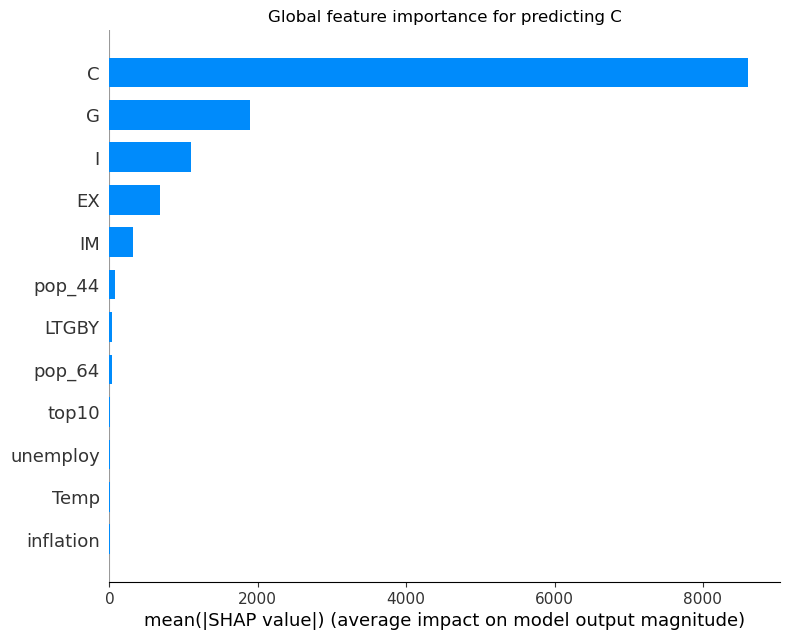

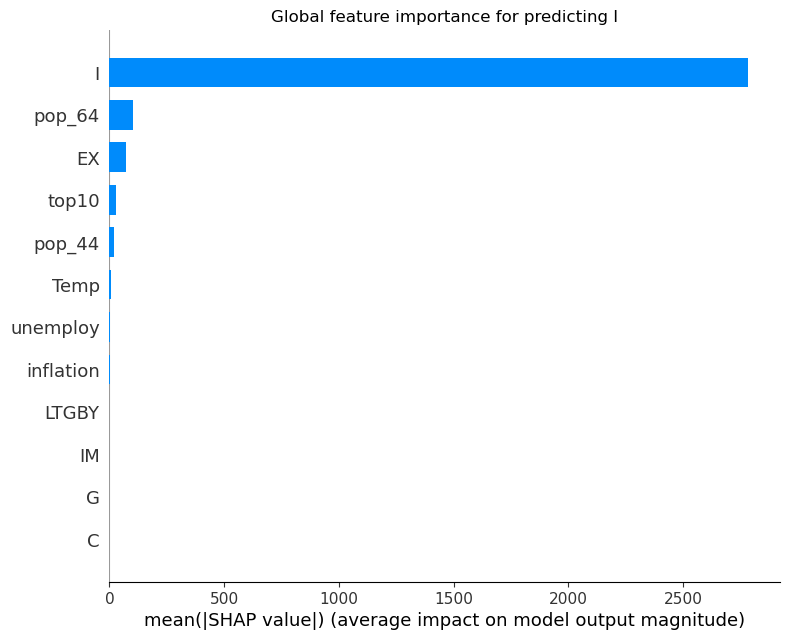

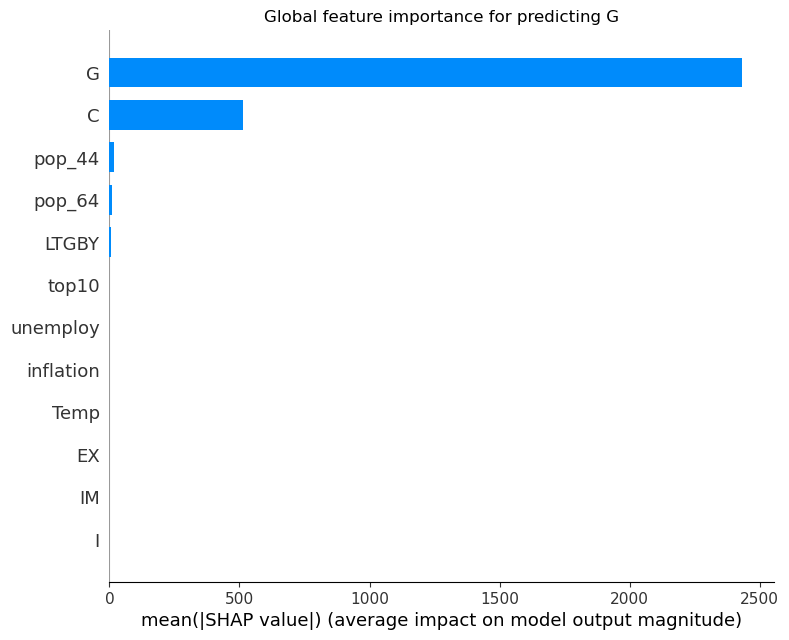

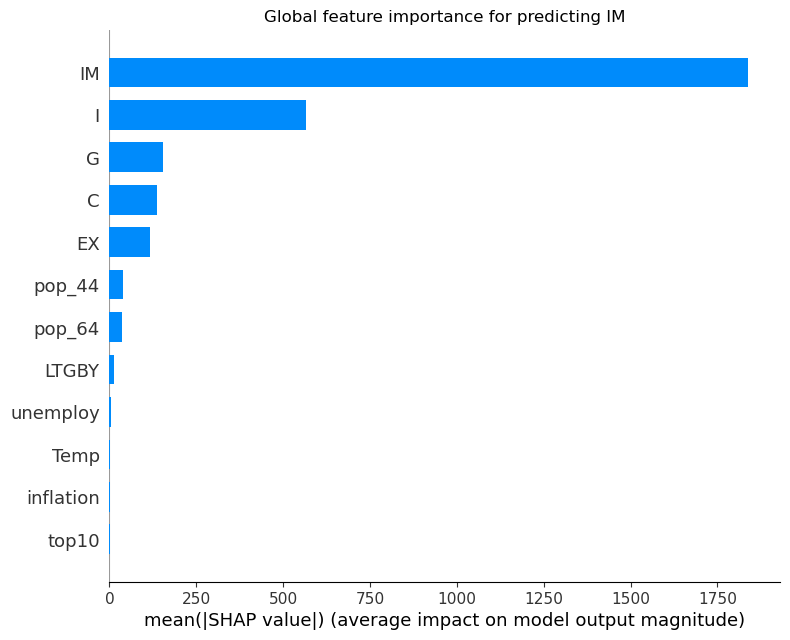

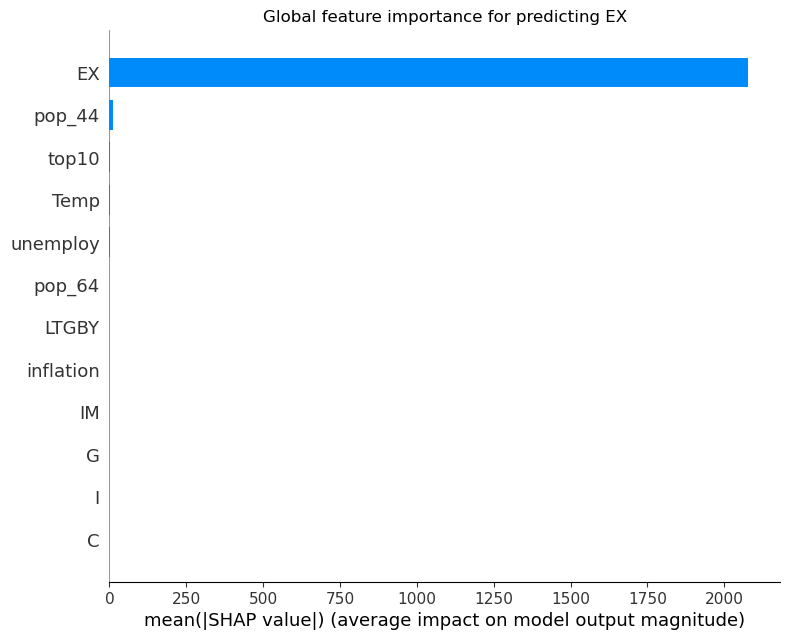

In [87]:
import shap
import matplotlib 
from matplotlib import pylab as plt

explainer = {}
shap_value = {}
masker = shap.maskers.Independent(data=X_train_prep['C'])
feature_names = main_form.columns
for i in ['C', 'I', 'G', 'IM', 'EX']:  
    explainer[i] = shap.Explainer(lambda x: final_best_model[i].predict(x), masker)
    shap_value[i] = explainer[i](X_test_prep[i])
    shap.summary_plot(shap_value[i], plot_type="bar", feature_names=feature_names, show=False)
    # print(shap_value[i])
    # fig, ax = plt.gcf(), plt.gca()
    # current_labels = [item.get_text() for item in ax.get_yticklabels()]
    # print(current_labels)
    # new_labels = main_form.columns
    # # ax.set_yticklabels(new_labels)
    plt.title('Global feature importance for predicting {}'.format(i))

    plt.show()

**The figures presented above reveal some interesting patterns. G, I, IM, EX contribute significantly to the prediction of C, C contributes significantly to the prediciton of G, and I, G, C, EX contribut siginificantly to the prediction of IM**

# This is the end of the project... But you can go to project_part2.ipynb if you still have some interest...
